<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <center><h1 style="font-size: 50px; color: white; text-shadow: 0 0 5px black, 0 0 5px black;"><b>3. Plane Classifier - Scratch</b></h1></center>
    <center><h1 style="font-size: 30px; color: white;  text-shadow: 0 0 5px black, 0 0 5px black;">Computer Vision</h1></center>
    <br>
    <br>
    <br>
    <br>
    <br>
    <div style="color: white; margin-left:  5%; font-size: 20px;">
        <p>Realizado por: </p>
        <ul>
            <li>Beatriz Santos, nº 108593</li>
            <li>João Ferreira, nº 88639</li>
            <li>Rodrigo Sarroeira, nº 92761</li>
        </ul>
    </div>        
    <br>
    <br>
    <br><br></div>

In [1]:
import datetime
now = datetime.datetime.now()
print("Current date and time: ")
print(str(now))

Current date and time: 
2023-01-23 11:36:57.101766


In [2]:
import os
import pickle
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.applications import EfficientNetB0, MobileNet
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, Flatten

logging.disable(logging.WARNING)
logging.disable(logging.INFO)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">1. Split Dataset</h1>
</div>

In [3]:
# Define parameters
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED = 1245
NUM_CLASSES = 7

dataset_location = "images\crop_new"

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_location,
  labels='inferred',
  label_mode = 'categorical',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 21000 files belonging to 7 classes.
Using 16800 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_location,
  labels='inferred',
  label_mode = 'categorical',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 21000 files belonging to 7 classes.
Using 4200 files for validation.


In [7]:
print("There is {} batches of 128 images in the training dataset".format(len(train_ds)))
print("There is {} batches of 128 images in the validation dataset".format(len(val_ds)))

There is 132 batches of 128 images in the training dataset
There is 33 batches of 128 images in the validation dataset


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">2. Data Classes and Examples</h1>
</div>

In [9]:
# Class labels
labels = train_ds.class_names
print(labels)

['Ataque', 'Bombardeiro', 'Busca_e_salvamento', 'Caca', 'Caca-bombardeiro', 'Reconhecimento', 'Transporte']


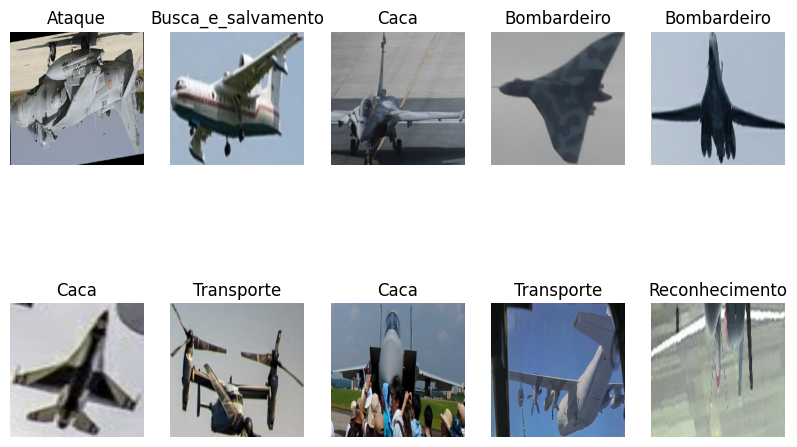

In [9]:
plt.figure(1, figsize=(10, 10))
for x_batch, y_batch in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(x_batch[i].numpy().astype("uint8"))
        plt.title(labels[np.argmax(y_batch[i,:])])
        plt.axis("off")

plt.show()

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">3. Efficient Net Trainning</h1>
</div>

In [10]:
# Optimize memory by allowing cached images
train_ds = train_ds.cache()
val_ds = val_ds.cache()
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Import EfficientNetB0 - Make the parameters trainable, so they fit to the new images
EfficientNetmodel = EfficientNetB0(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
EfficientNetmodel.summary()
EfficientNetmodel.trainable = True

16705208/16705208 [==============================] - 5s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

                                                                  'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization) 

 block3b_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3a_project_bn[0][0]']     
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)

 block6b_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)         (None, 7, 7, 192)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_e

In [12]:
model1 = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    EfficientNetmodel,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

In [13]:
model1.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                        

In [15]:
Modle_Checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ClassNets/EfficientNetB0.h5',
    monitor='val_accuracy',
    save_best_only='True',
    verbose=1)

In [16]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
    restore_best_weights='True',
    min_delta=0.01)

In [17]:
epochs = 100
modelEfficientNet = model1.fit(train_ds, 
                    validation_data = val_ds,
                    callbacks=[Early_Stopping, Modle_Checkpoint],
                    epochs=epochs)

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 1.2932 - accuracy: 0.5613 
Epoch 1: val_accuracy improved from -inf to 0.14286, saving model to models/5classes\EfficientNetB0.h5
132/132 [==============================] - 3119s 23s/step - loss: 1.2932 - accuracy: 0.5613 - val_loss: 2.5823 - val_accuracy: 0.1429
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.7942 
Epoch 2: val_accuracy improved from 0.14286 to 0.17667, saving model to models/5classes\EfficientNetB0.h5
132/132 [==============================] - 3044s 23s/step - loss: 0.5858 - accuracy: 0.7942 - val_loss: 3.3709 - val_accuracy: 0.1767
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8613 
Epoch 3: val_accuracy did not improve from 0.17667
132/132 [==============================] - 3275s 25s/step - loss: 0.4092 - accuracy: 0.8613 - val_loss: 3.1105 - val_accuracy: 0.1705
Epoch 4/100
132/132 [=======================

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">4. Efficient Net Evaluation</h1>
</div>

In [48]:
y_pred = model1.predict(val_ds)
y_pred = tf.argmax(y_pred, axis=1)

33/33 [==============================] - 178s 5s/step


In [49]:
y_true = tf.concat([y for x, y in val_ds], axis=0)
y_true = tf.argmax(y_true, axis=1)

In [51]:
acc = modelEfficientNet.history['accuracy']
val_acc = modelEfficientNet.history['val_accuracy']
loss = modelEfficientNet.history['loss']
val_loss = modelEfficientNet.history['val_loss']
epochs_range = modelEfficientNet.epoch

Text(0.5, 1.0, 'Training and Validation Loss')

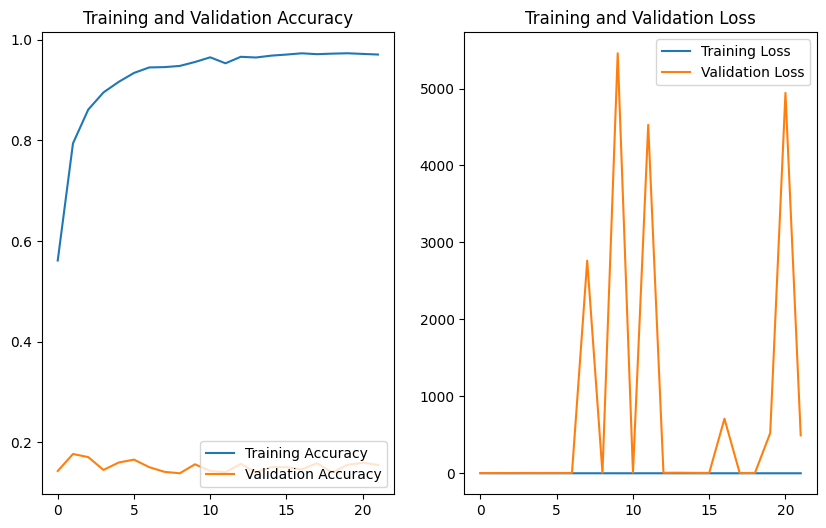

In [53]:
plt.figure(2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, max(epochs_range) + 1), acc, label='Training Accuracy')
plt.plot(range(0, max(epochs_range) + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(0, max(epochs_range) + 1), loss, label='Training Loss')
plt.plot(range(0, max(epochs_range) + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

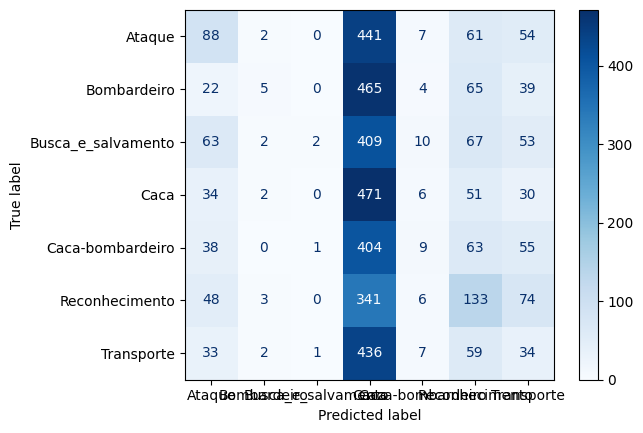

In [54]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [55]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy =", accuracy)

Accuracy = 0.17666666666666667


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">5. Mobile Net Trainning</h1>
</div>

In [25]:
# importar o EfficientNetB0 - considerando apenas a parte de geracao de features dessa rede
MobileNetmodel = MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
MobileNetmodel.summary()
MobileNetmodel.trainable = True

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [26]:
model2 = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    MobileNetmodel,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

In [27]:
model2.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [29]:
Modle_Checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ClassNets/MobileNet.h5',
    monitor='val_accuracy',
    save_best_only='True',
    verbose=1)

In [30]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
    restore_best_weights='True',
    min_delta=0.01)

In [31]:
epochs = 100
modelMobileNet = model2.fit(train_ds, 
                    validation_data = val_ds,
                    callbacks=[Early_Stopping, Modle_Checkpoint],
                    epochs=epochs)

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 3.2564 - accuracy: 0.3381
Epoch 1: val_accuracy improved from -inf to 0.22881, saving model to models/5classes\MobileNet.h5
132/132 [==============================] - 1307s 10s/step - loss: 3.2564 - accuracy: 0.3381 - val_loss: 3.4456 - val_accuracy: 0.2288
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 1.0293 - accuracy: 0.6115
Epoch 2: val_accuracy improved from 0.22881 to 0.52357, saving model to models/5classes\MobileNet.h5
132/132 [==============================] - 1325s 10s/step - loss: 1.0293 - accuracy: 0.6115 - val_loss: 1.8387 - val_accuracy: 0.5236
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.7306
Epoch 3: val_accuracy did not improve from 0.52357
132/132 [==============================] - 1337s 10s/step - loss: 0.7334 - accuracy: 0.7306 - val_loss: 1.7904 - val_accuracy: 0.5193
Epoch 4/100
132/132 [==============================] - ET

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">6. Mobile Net Evaluation</h1>
</div>

In [32]:
# opter as predicoes e ground thruth num formato mais facil  de tratar (um vetor de ids das classes)
y_pred = model2.predict(val_ds)
y_pred = tf.argmax(y_pred, axis=1)

33/33 [==============================] - 101s 3s/step


In [33]:
y_true = tf.concat([y for x, y in val_ds], axis=0)
y_true = tf.argmax(y_true, axis=1)

In [35]:
acc = modelMobileNet.history['accuracy']
val_acc = modelMobileNet.history['val_accuracy']
loss = modelMobileNet.history['loss']
val_loss = modelMobileNet.history['val_loss']
epochs_range = modelMobileNet.epoch

In [36]:
range(0, max(epochs_range))

range(0, 76)

Text(0.5, 1.0, 'Training and Validation Loss')

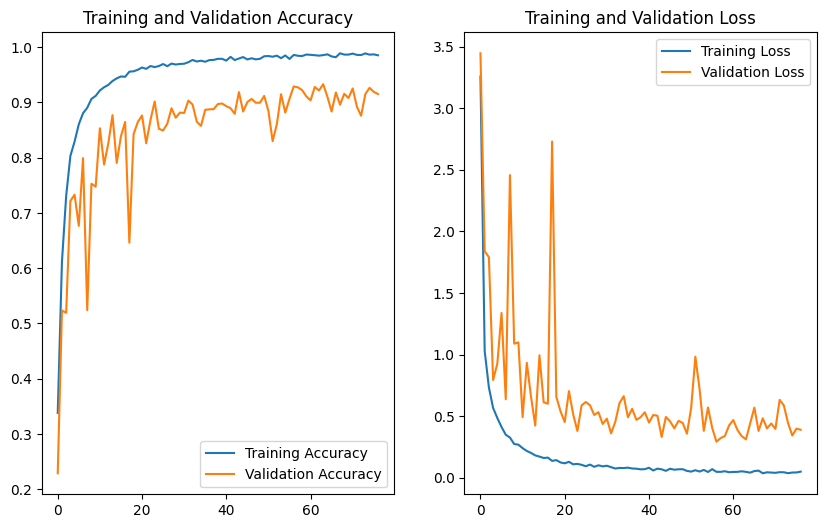

In [37]:
plt.figure(2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, max(epochs_range) + 1), acc, label='Training Accuracy')
plt.plot(range(0, max(epochs_range) + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(0, max(epochs_range) + 1), loss, label='Training Loss')
plt.plot(range(0, max(epochs_range) + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

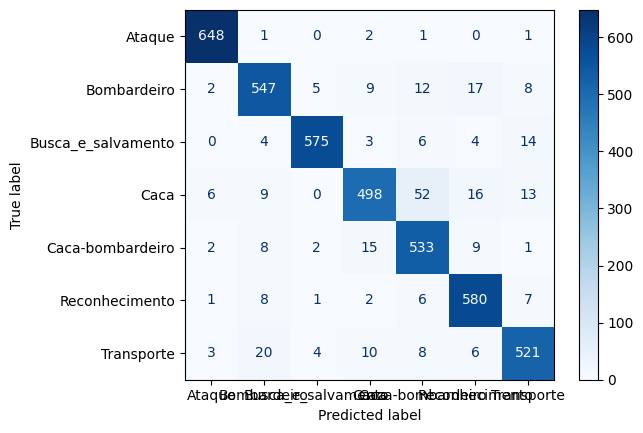

In [38]:
# Confusion Matrix
cm2 = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [45]:
accuracy = accuracy_score(y_true, y_pred)
print("Accurary =", accuracy)

Accurary = 0.929047619047619


In [39]:
now = datetime.datetime.now()
print("Current date and time: ")
print(str(now))

Current date and time: 
2023-01-19 20:38:11.600424
